In [ ]:
# all necessary libraries imported here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping

In [ ]:

# Load the data
df = pd.read_csv('/content/drive/MyDrive/soil_moisture_Dataset/updated_data.csv')

# Data overview
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Descriptive statistics
print("\nDescriptive statistics of the dataset:")
print(df.describe())



Dataset Shape: (321584, 8)

First 5 rows of the dataset:
         time  latitude  longitude  clay_content  sand_content  silt_content  \
0  2013-01-03    54.875      9.125           5.0          86.0           9.0   
1  2013-01-05    54.875      9.125           5.0          86.0           9.0   
2  2013-01-07    54.875      9.125           5.0          86.0           9.0   
3  2013-01-08    54.875      9.125           5.0          86.0           9.0   
4  2013-01-09    54.875      9.125           5.0          86.0           9.0   

     sm_aux  sm_tgt  
0  0.454120    0.53  
1  0.437102    0.44  
2  0.412978    0.42  
3  0.378734    0.55  
4  0.350740    0.46  

Missing values in each column:
time            0
latitude        0
longitude       0
clay_content    0
sand_content    0
silt_content    0
sm_aux          0
sm_tgt          0
dtype: int64

Descriptive statistics of the dataset:
            latitude      longitude  clay_content   sand_content  \
count  321584.000000  321584.0000

In [ ]:
# Determine unique latitude-longitude pairs
unique_locations = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
print(f"There are {unique_locations.shape[0]} unique locations in the dataset.")

There are 1166 unique locations in the dataset.


In [ ]:
m = folium.Map(location=[51.1657, 10.4515], zoom_start=5, tiles="OpenStreetMap", width=800, height=800)

# Add unique locations to the map
for idx, row in unique_locations.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

# Display the map directly
m

In [ ]:
unique_locations.head()

,latitude,longitude
0,54.875,9.125
1,54.875,9.375
2,54.875,9.875
3,54.625,9.125
4,54.625,9.375


In [ ]:
unique_locations.isnull().sum()

latitude     0
longitude    0
dtype: int64

In [ ]:
unique_locations = unique_locations.dropna()

In [ ]:
m = folium.Map(location=[51.1657, 10.4515], zoom_start=5, tiles="OpenStreetMap", width=800, height=800)

# Add unique locations to the map
for idx, row in unique_locations.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

# Display the map directly
m

In [ ]:
#Oh, I thought dataset only encompasses Germany, but I think it goes beyond Germany into Denmark, France, Belgium, and other neighboring European countries.
 #So really, the dataset encompasses many countries in Europe. I didn't know this prior to this plot.

In [ ]:
# Create a unique identifier for each location
df['location_id'] = df.groupby(['latitude', 'longitude']).ngroup()
# Determine the start and end of the time series
start_date = df['time'].min()
end_date = df['time'].max()
print(f"The time series starts on {start_date} and ends on {end_date}.")

The time series starts on 2013-01-01 and ends on 2013-12-31.


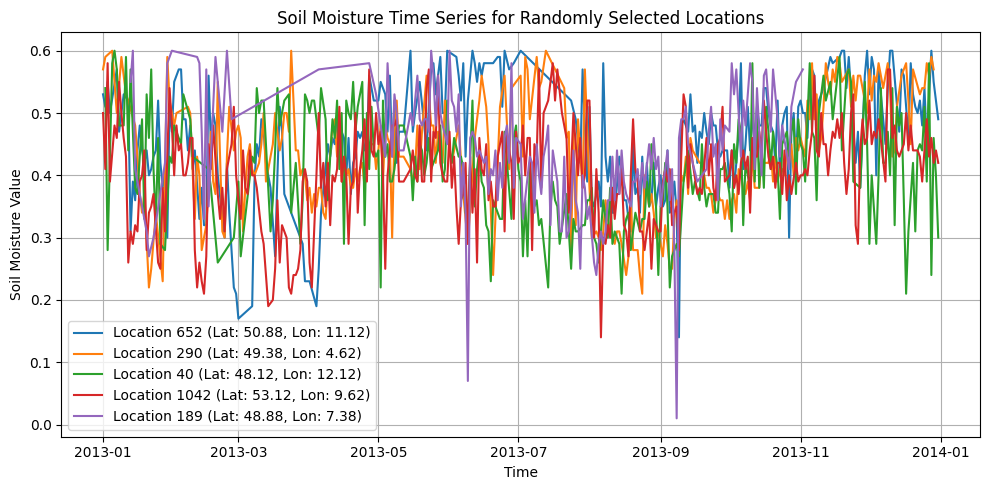

In [ ]:
# Randomly select five unique location IDs
random_locations = np.random.choice(df['location_id'].unique(), 5, replace=False)

# Plot time series data for the selected locations
plt.figure(figsize=(10, 5))
for location in random_locations:
    subset = df[df['location_id'] == location]
    lat = subset['latitude'].iloc[0]
    lon = subset['longitude'].iloc[0]
    plt.plot(pd.to_datetime(subset['time']), subset['sm_tgt'], label=f"Location {location} (Lat: {lat:.2f}, Lon: {lon:.2f})")

plt.title("Soil Moisture Time Series for Randomly Selected Locations")
plt.xlabel("Time")
plt.ylabel("Soil Moisture Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

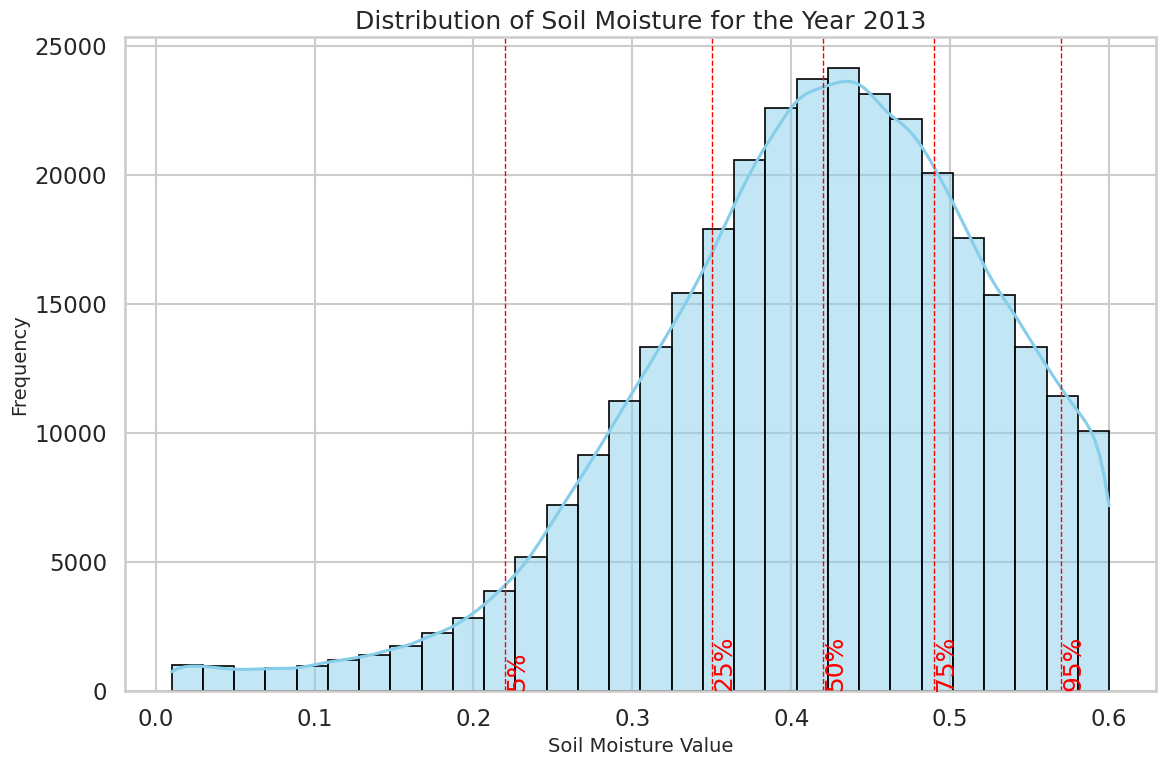

In [ ]:
# Set style and context to make the plot look fancy
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the distribution plot
plt.figure(figsize=(12, 8))
sns.histplot(df['sm_tgt'], kde=True, bins=30, color='skyblue', edgecolor='black', linewidth=1.2)

# Mark percentiles on the plot
percentiles = [5, 25, 50, 75, 95]
for percentile in percentiles:
    value = np.percentile(df['sm_tgt'], percentile)
    plt.axvline(value, color='red', linestyle='dashed', linewidth=1)
    plt.text(value, 5, f'{percentile}%', color='red', rotation=90, verticalalignment='bottom')

# Set the title and labels
plt.title("Distribution of Soil Moisture for the Year 2013", fontsize=18)
plt.xlabel("Soil Moisture Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
#What we see in Histogram
#Less than 5% of soil moisture values indicate very dry conditions.
#Below 20% of the data points show soil moisture values that can be categorized as somewhat low,
# with a threshold of 0.25 differentiating between sufficiently irrigated and not sufficiently irrigated regions.
#A significant proportion, more than 50%, of the land has soil moisture values below 40%, highlighting potential areas of concern.
#These observations shed light on the distribution and potential challenges related to soil moisture in the studied regions for the year 2013


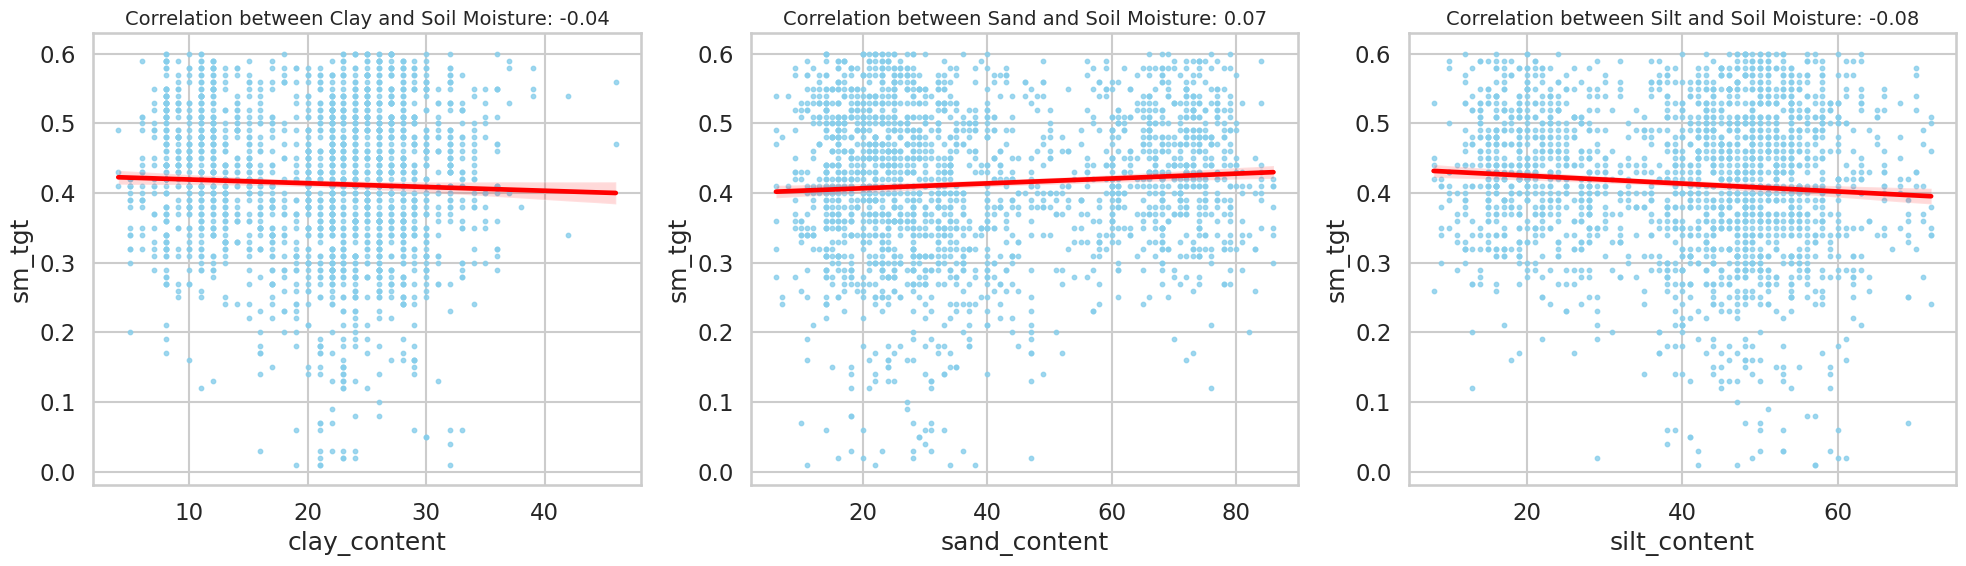

In [ ]:
# Randomly sample 2000 data points from the dataframe
sample_df = df.sample(n=2000, random_state=42)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")
sns.set_context("talk")

# Initialize a figure with three subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# List of soil components
components = ['clay_content', 'sand_content', 'silt_content']

# Plot scatter plots for each component
for i, component in enumerate(components):
    sns.regplot(x=component, y='sm_tgt', data=sample_df, ax=axes[i], color='skyblue', scatter_kws={'s':10}, line_kws={'color':'red'})

    # Calculate correlation and annotate the plot with its value
    correlation = sample_df[component].corr(sample_df['sm_tgt'])
    axes[i].set_title(f"Correlation between {component.split('_')[0].capitalize()} and Soil Moisture: {correlation:.2f}", fontsize=14)

# Adjust layout for better display
plt.tight_layout()
plt.show()

In [ ]:
# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Separate the data for June
june_data = df[df['time'].dt.month == 6]

# Remove June data from the main dataframe
df = df[df['time'].dt.month != 6]

june_data.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt,location_id
96,2013-06-01,54.875,9.125,5.0,86.0,9.0,0.132296,0.35,1163
97,2013-06-02,54.875,9.125,5.0,86.0,9.0,0.111909,0.31,1163
98,2013-06-03,54.875,9.125,5.0,86.0,9.0,0.099585,0.32,1163
99,2013-06-04,54.875,9.125,5.0,86.0,9.0,0.081596,0.32,1163
100,2013-06-05,54.875,9.125,5.0,86.0,9.0,0.098436,0.31,1163


In [ ]:
#LSTM use gradient descent to update the network weights during training
#Features that have a larger scale can dominate the cost function and make the optimization process
# more challenging, leading to longer training times and a model that might not converge

#MinMaxScaler to scale our data


# Features to normalize
features_to_normalize = ['latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id','sm_tgt']

# Initialize scaler
scaler = MinMaxScaler()

# Apply normalization to the dataframe (both training and June data)
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
june_data[features_to_normalize] = scaler.transform(june_data[features_to_normalize])

# Reorder the columns to ensure 'sm_tgt' is the last column
ordered_columns = ['time', 'latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id', 'sm_tgt']
df = df[ordered_columns]
june_data = june_data[ordered_columns]

df.head()

<ipython-input-18-e556b8a01dfe>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])


,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,location_id,sm_tgt
0,2013-01-03,1.0,0.509091,0.02381,1.0,0.015625,0.585957,0.999141,0.881356
1,2013-01-05,1.0,0.509091,0.02381,1.0,0.015625,0.565721,0.999141,0.728814
2,2013-01-07,1.0,0.509091,0.02381,1.0,0.015625,0.537036,0.999141,0.694915
3,2013-01-08,1.0,0.509091,0.02381,1.0,0.015625,0.496316,0.999141,0.915254
4,2013-01-09,1.0,0.509091,0.02381,1.0,0.015625,0.463029,0.999141,0.762712


In [ ]:
june_data.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,location_id,sm_tgt
96,2013-06-01,1.0,0.509091,0.02381,1.0,0.015625,0.203279,0.999141,0.576271
97,2013-06-02,1.0,0.509091,0.02381,1.0,0.015625,0.179037,0.999141,0.508475
98,2013-06-03,1.0,0.509091,0.02381,1.0,0.015625,0.164383,0.999141,0.525424
99,2013-06-04,1.0,0.509091,0.02381,1.0,0.015625,0.142992,0.999141,0.525424
100,2013-06-05,1.0,0.509091,0.02381,1.0,0.015625,0.163016,0.999141,0.508475


In [ ]:
# Calculate the number of data points for each location in june_data
data_points_per_location = june_data.groupby('location_id').size()

# Identify locations with less than 15 days of data
locations_to_exclude = data_points_per_location[data_points_per_location < 15].index

# Filter out these locations from june_data
june_data = june_data[~june_data['location_id'].isin(locations_to_exclude)]

In [ ]:
def create_sequences(data, seq_length):
    """
    Create input-output sequence pairs from the provided dataframe.
    """
    X, Y = [], []

    for location, group in data.groupby('location_id'):
        # Extract relevant features from the group
        features = group[features_to_normalize].drop(columns='sm_tgt').values
        targets = group['sm_tgt'].values

        # Create sequences
        for i in range(len(features) - seq_length):
            X.append(features[i:i+seq_length])
            Y.append(targets[i+seq_length])

    return X, Y

# Define the sequence length (30 days)
seq_length = 15

# Create sequences for training data
X, Y = create_sequences(df, seq_length)

# Convert lists to numpy arrays for easier handling later
X = np.array(X)
Y = np.array(Y)

X.shape, Y.shape

((277893, 15, 7), (277893,))

In [ ]:
# LSTM MODel

Epoch 1/10
1737/1737 [==============================] - 114s 63ms/step - loss: 0.0682 - val_loss: 0.0223
Epoch 2/10
1737/1737 [==============================] - 110s 63ms/step - loss: 0.0312 - val_loss: 0.0257
Epoch 3/10
1737/1737 [==============================] - 109s 63ms/step - loss: 0.0294 - val_loss: 0.0541
Epoch 4/10
1737/1737 [==============================] - 108s 62ms/step - loss: 0.0286 - val_loss: 0.1854
Epoch 4: early stopping


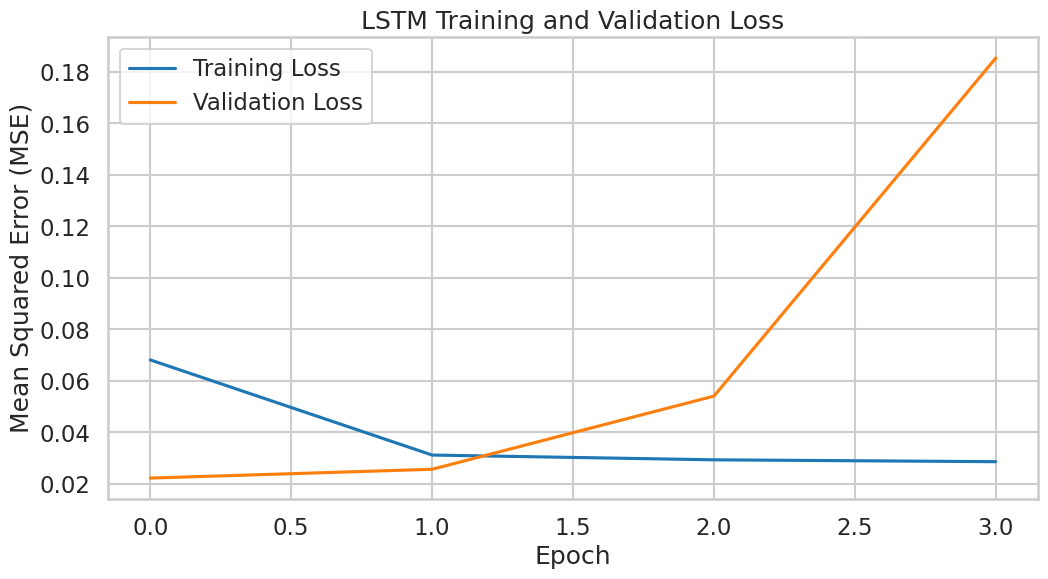

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense
from keras.regularizers import l2

model = Sequential()
model.add(LSTM(75, activation='relu', input_shape=(X.shape[1], X.shape[2]), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), return_sequences=True))
model.add(LSTM(75, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Dense output layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, Y, epochs=10, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stop])

# Plot the training and validation loss

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for units in mlp_units:
        x = Dense(units, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs, outputs)

input_shape = (120, 64)  # Example input shape (sequence_length, features)
head_size = 64
num_heads = 4
ff_dim = 256
num_transformer_blocks = 4
mlp_units = [128]

model = build_transformer_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=0.1,
    mlp_dropout=0.1
)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 64)]            0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 120, 64)              128       ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 120, 64)              66368     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 120, 128)          74496     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 113857 (444.75 KB)
Trainable params: 113857 (444.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
29/

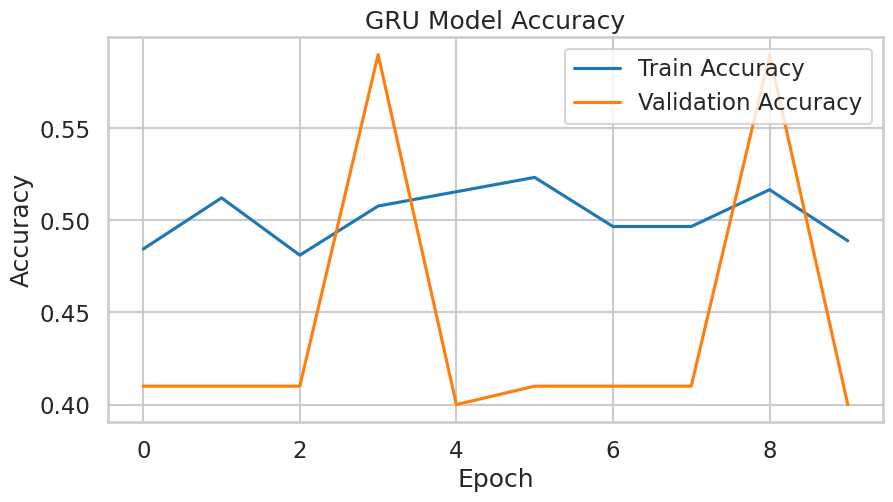

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Simulated data (substitute with real data in practice)
np.random.seed(0)
X_train = np.random.rand(1000, 120, 64)  # 1000 samples, 120 time steps, 64 features
y_train = np.random.randint(0, 2, size=1000)  # Binary target

X_test = np.random.rand(200, 120, 64)  # 200 samples for testing
y_test = np.random.randint(0, 2, size=200)

# Build the model
model = Sequential([
    GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 120, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 109377 (427.25 KB)
Trainable params: 109

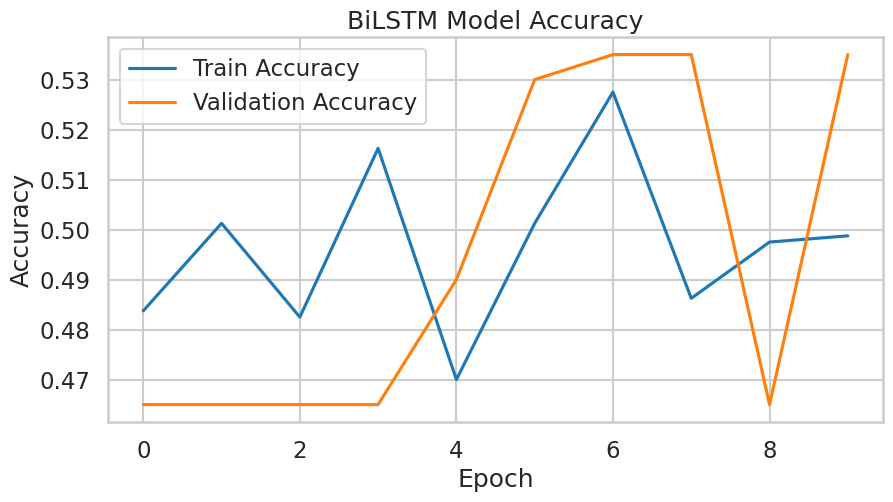

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

# Simulated data (replace with actual data for practical use)
np.random.seed(0)
X_train = np.random.rand(1000, 120, 64)  # 1000 samples, 120 time steps, 64 features
y_train = np.random.randint(0, 2, size=1000)  # Binary target

X_test = np.random.rand(200, 120, 64)  # 200 samples for testing
y_test = np.random.randint(0, 2, size=200)

# Build the model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('BiLSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


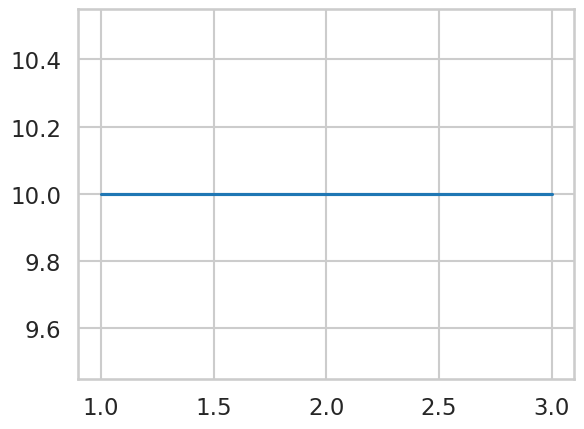

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
x = np.array([1, 2, 3])  # Shape: (3,)
y = np.array([10])       # Shape: (1,)

# Broadcast y to match the shape of x
y_broadcasted = np.full_like(x, y)  # Shape: (3,)

# Plotting
plt.plot(x, y_broadcasted)
plt.show()


In [ ]:
# Flatten the X array
X = X.flatten()


# Import the correct model library
from sklearn.linear_model import LinearRegression

# Create a LinearRegression model
model = LinearRegression()

# Flatten the X array
X = X.flatten()

# Print the shape of X
print(X.shape)

print(type(model))

(29178765,)
<class 'sklearn.linear_model._base.LinearRegression'>


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_june = scaler.fit_transform(X_june.reshape(-1, 1))

In [ ]:

X_june = X_june.reshape(-1, X_june.shape[-1])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:



# Make predictions
predictions = model.predict(X_june, batch_size=64)

16666/16666 [==============================] - 27s 2ms/step


\

In [ ]:


def reverse_scaling(data, scaler):
    """
    Reverse the scaling effect on data.
    """
    # Convert data to a 2D array if it's 1D
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)

    dummy = np.zeros((len(data), len(features_to_normalize)))

    # Set the last column of the dummy array to your data
    dummy[:, -1] = data.ravel()

    # Use inverse_transform to reverse the scaling
    unscaled = scaler.inverse_transform(dummy)

    # Return the last column (our actual unscaled data)
    return unscaled[:, -1]

In [ ]:
# Reverse scaling for Y_june_true and predictions
Y_june_true_unscaled = reverse_scaling(Y_june_true, scaler)
predictions_unscaled = reverse_scaling(predictions, scaler)

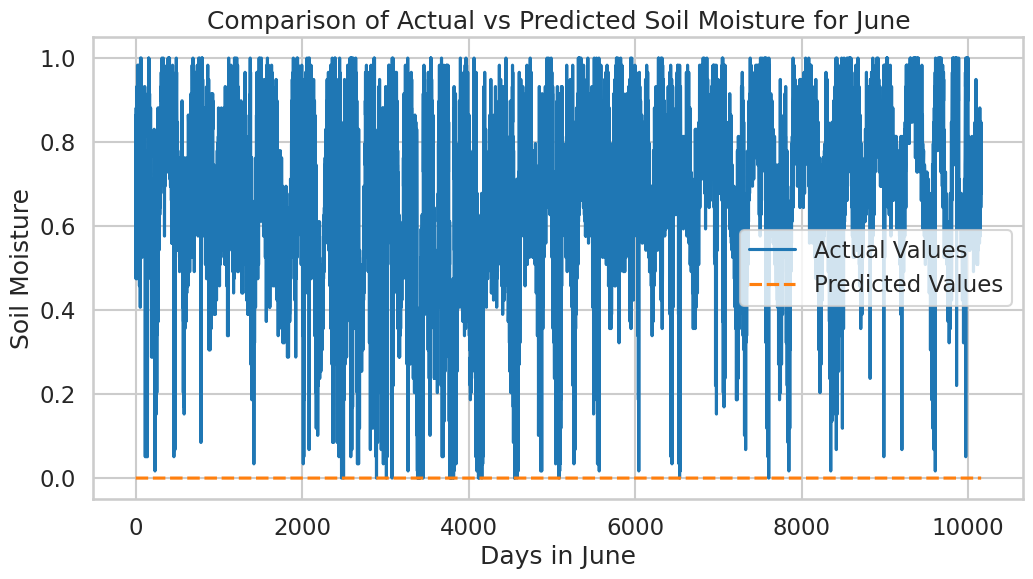

In [ ]:

# Ensure both arrays are of the same length
min_length = min(len(Y_june_true_unscaled), len(predictions_unscaled))
Y_june_true_unscaled = Y_june_true_unscaled[:min_length]
predictions_unscaled = predictions_unscaled[:min_length]

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual Values': Y_june_true_unscaled,
    'Predicted Values': predictions_unscaled
})

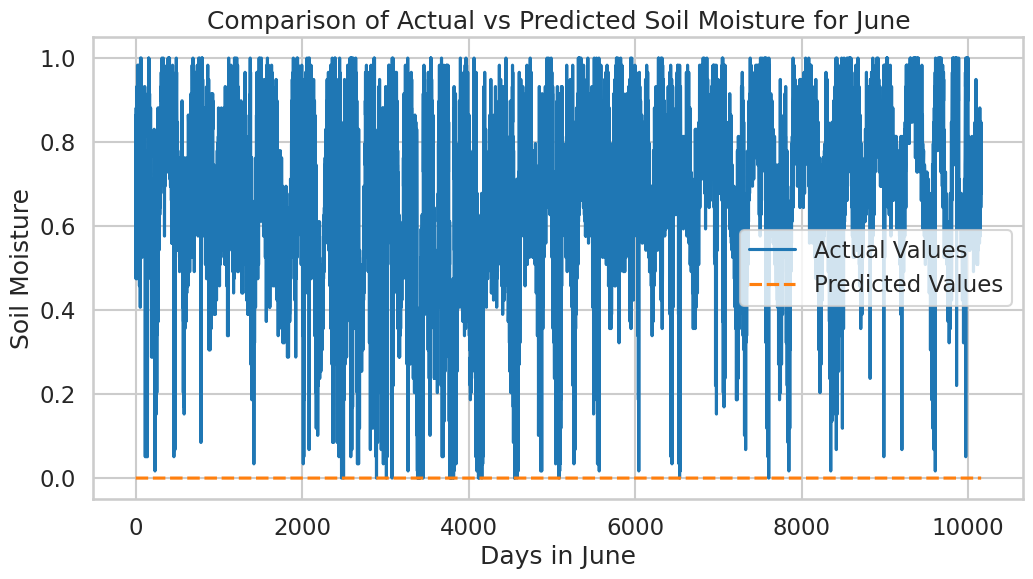

In [ ]:


# Ensure both arrays are 1-dimensional
Y_june_true_unscaled = Y_june_true_unscaled.ravel()
predictions_unscaled = predictions_unscaled.ravel()

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual Values': Y_june_true_unscaled,
    'Predicted Values': predictions_unscaled
})

# Set Seaborn style
sns.set_style("whitegrid")

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot)
plt.title('Comparison of Actual vs Predicted Soil Moisture for June')
plt.ylabel('Soil Moisture')
plt.xlabel('Days in June')
plt.legend()
plt.show()

In [ ]:

# Calculate MAE
mae = np.mean(np.abs(Y_june_true_unscaled - predictions_unscaled))
print(f"Mean Absolute Error for June Predictions: {mae}")

Mean Absolute Error for June Predictions: 0.684017940272508


In [ ]:

import numpy as np

# Assuming Y_june_true_unscaled and predictions_unscaled are the true and predicted values respectively
tolerance = 5  # or any value you find appropriate based on your specific case

# Calculate the absolute difference and check if within tolerance
accurate_predictions = np.abs(Y_june_true_unscaled - predictions_unscaled) <= tolerance

# Calculate accuracy as the percentage of predictions within the tolerance
accuracy = np.mean(accurate_predictions) * 100  # Convert fraction to percentage
print(f"Accuracy within a tolerance of {tolerance}: {accuracy:.2f}%")



Accuracy within a tolerance of 5: 100.00%


In [ ]:
# Calculate MAE
mse = np.mean(np.abs(Y_june_true_unscaled - predictions_unscaled))
print(f"Mean Absolute Error for June Predictions: {mse}")

Mean Absolute Error for June Predictions: 0.684017940272508
